# Transfer Learning with TensorFlow Part 1: Feature Extraction
Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are 2 benefits:
1. Can leverage existing neural network architectures proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU
!nvidia-smi

Mon Aug  2 14:40:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |    865MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from food101)

import zipfile

# Download the file
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2021-08-02 14:40:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   254MB/s    in 0.6s    

2021-08-02 14:40:04 (254 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} in "{dirpath}"')

There are 2 directories and 0 in "10_food_classes_10_percent"
There are 10 directories and 0 in "10_food_classes_10_percent/train"
There are 0 directories and 75 in "10_food_classes_10_percent/train/ice_cream"
There are 0 directories and 75 in "10_food_classes_10_percent/train/chicken_curry"
There are 0 directories and 75 in "10_food_classes_10_percent/train/ramen"
There are 0 directories and 75 in "10_food_classes_10_percent/train/hamburger"
There are 0 directories and 75 in "10_food_classes_10_percent/train/grilled_salmon"
There are 0 directories and 75 in "10_food_classes_10_percent/train/chicken_wings"
There are 0 directories and 75 in "10_food_classes_10_percent/train/sushi"
There are 0 directories and 75 in "10_food_classes_10_percent/train/fried_rice"
There are 0 directories and 75 in "10_food_classes_10_percent/train/steak"
There are 0 directories and 75 in "10_food_classes_10_percent/train/pizza"
There are 10 directories and 0 in "10_food_classes_10_percent/test"
There are 0 d

### Creating data loaders
Use `ImageDataGenerator`

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
train_data_10_percent

### Setting up callbacks (things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoar callback (functionize because we need to create a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_call = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_call

## Creating models using TensorFlow Hub
In the past we've used Tensorflow to create our own models layer by layer from scratch.  
Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. (Access pretrained models at https://tfhub.dev/)

In [ ]:
# Compare the following 2 models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE, IMAGE_SHAPE + (3, )

((224, 224), (224, 224, 3))

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # IMAGE_SHAPE: (224, 224) -> (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model


In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile the resnet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210802-170304
Epoch 1/5
24/24 [==============================] - 20s 726ms/step - loss: 1.9748 - accuracy: 0.3373 - val_loss: 1.2542 - val_accuracy: 0.6056
Epoch 2/5
24/24 [==============================] - 14s 620ms/step - loss: 0.9153 - accuracy: 0.7293 - val_loss: 0.8488 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 14s 612ms/step - loss: 0.6347 - accuracy: 0.8160 - val_loss: 0.7509 - val_accuracy: 0.7644
Epoch 4/5
24/24 [==============================] - 14s 615ms/step - loss: 0.4845 - accuracy: 0.8640 - val_loss: 0.6908 - val_accuracy: 0.7812
Epoch 5/5
24/24 [==============================] - 15s 650ms/step - loss: 0.3882 - accuracy: 0.9093 - val_loss: 0.6794 - val_accuracy: 0.7760


In [ ]:
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Training accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

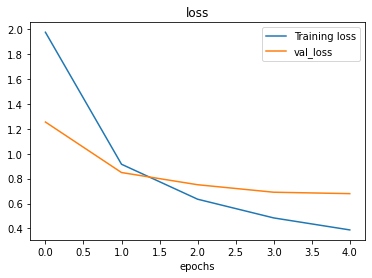

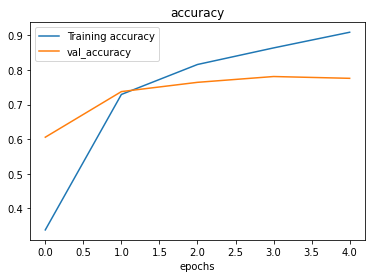

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Mode

In [ ]:
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
efficientnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


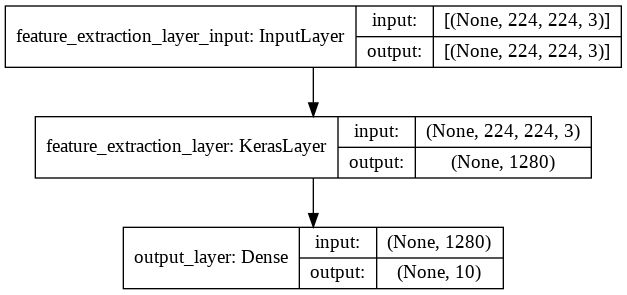

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(efficientnet_model, show_shapes=True)

In [ ]:
efficientnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                      experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210802-173914
Epoch 1/5
24/24 [==============================] - 25s 766ms/step - loss: 1.8629 - accuracy: 0.4493 - val_loss: 1.3104 - val_accuracy: 0.6996
Epoch 2/5
24/24 [==============================] - 14s 618ms/step - loss: 1.0657 - accuracy: 0.7693 - val_loss: 0.8775 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 14s 601ms/step - loss: 0.7587 - accuracy: 0.8347 - val_loss: 0.7016 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 14s 609ms/step - loss: 0.6094 - accuracy: 0.8640 - val_loss: 0.6138 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5135 - accuracy: 0.8867 - val_loss: 0.5613 - val_accuracy: 0.8580


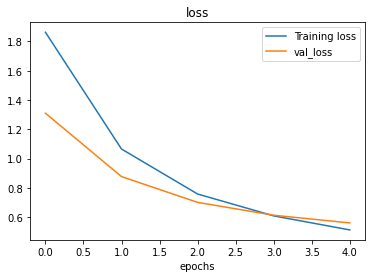

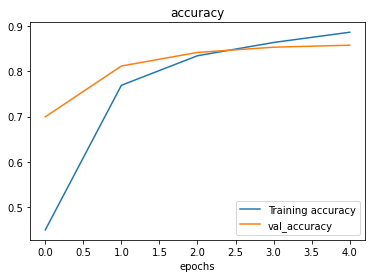

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning
* **As is** trannsfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes)
* **Feature extraction** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem. (e.g. 1000 classes -> 10 classes)
* **Fine-tuning** transfer learning - use the prelearned patterns of an existing model and "fine-tune" or all of the underlying layers (including new output layers)


## Comparing out model results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet 50V2" \
--description "Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

2021-08-02 18:11:47.765561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

Tensorboard experiments are uploaded: https://tensorboard.dev/experiment/kC0EMPAnS86kKb0GEPzPUA/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2021-08-02 18:19:55.737983: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/kC0EMPAnS86kKb0GEPzPUA/
	Name                 EfficientNetB0 vs. ResNet 50V2
	Description          Comparing 2 different TF Hub feature extraction model architectures using 10% of the training data
	Id                   kC0EMPAnS86kKb0GEPzPUA
	Created              2021-08-02 18:12:39 (7 minutes ago)
	Updated              2021-08-02 18:12:49 (7 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              138
	Tensor bytes         0
	Binary object bytes  15505816
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id kC0EMPAnS86kKb0GEPzPUA